# Fenwick trees for quantum simulation of fermions

James Daniel Whitfield, Dartmouth College

## Abstract
Quantum computing in general and quantum simulation in particular are areas
of current excitement in academic and industrial circles.  A sustained focus
on quantum simulation of electrons and other fermionic systems has resulted
in a number of modalities for encoding fermionic wave functions on quantum
bits.  In this article, we focus on encodings based on the extend Fenwick
tree: the binary tree.  The approach used here is based on tree structures 
that can generalize a number of standardized qubit-to-fermion encodings. Given
a tree structure, we describe the representation of fermionic operators in 
terms of qubit operators.  We also describe an implementation in the Julia 
language implementation of spin-to-fermion transforms.

# Fenwick Trees 
Fenwick trees are a specific type of binary trees introduced in 1994 for the purpose of arithmetic coding. Earlier applications to binomial heaps appeared in the 1970's. They were rediscovered in 2000 by Bravyi and Kitaev in the context of quantum simulation. Recent work has further analyzed and simplified the the Bravyi-Kitaev presentation including various expositions (especially those by Peter Love and co-workers) and its recent use in experimental implementations of quantum simulations.

In [1]:
@time include("Trees.jl")

  7.698273 seconds (9.02 M allocations: 485.647 MiB, 4.51% gc time)


PlotTree (generic function with 1 method)

Binary tree structures are useful when both bit values (i.e. the occupancy $k_i$) and prefix sums ($\Gamma_j=(\sum_{i=1}^{j-1} k_i)$) are required. For the needs of the spin-to-fermion transforms considered here, we will assume that $\Gamma_j$ is evaluate in $\mathbf{Z}_2$ i.e. the parity of the sum.

In the implemented binary tree structure, each node has at most one parent but may have an arbitrary number of children.  (I don't think the single parent limitation is a fundamental limitation but it does capture the previously known fermionic encodings.) We store the tree structure with $M$ nodes as a length $M$ list with entry $j$ corresponding to the parent of node $j$.  If the node has no parent, a flag value is stored.

## Matrix representation

In this section we will define the general binary tree and the specific class 
we consider here. Further, we will define a number of sets that play an instrumental role in 
extracting prefix sums and antisymmetrical phases later. 

The binary tree has several fermionic occupancies ($\{k_i\in\{0,1\}\}_{i=1}^M$) 
summed to give a binary value stored at a particular node, $t_j=\sum_i \beta_{ji}k_i$, of the tree. 
This $\beta$ matrix representation was introduced by Seeley et al. in equations (16) and (23).

Note that the usual change of basis formula has $g_j=\sum_k C_{kj} f_k$.  Instead the paper has the formula as
$t_j=\sum_i \beta_{ji}k_i$.  For consistency, we have coded using the Seeley definition.


## Example 1

As we pointed out earlier, we assume each node has at most one 
parent. The parent of the $k$th tree node can be stored in 
bin $k$ of a linear tree list e.g. $\mathcal T_1=[2,3,1]$ would indicate that node one is a child of node two, two is a child of three and three is a child of node one. 

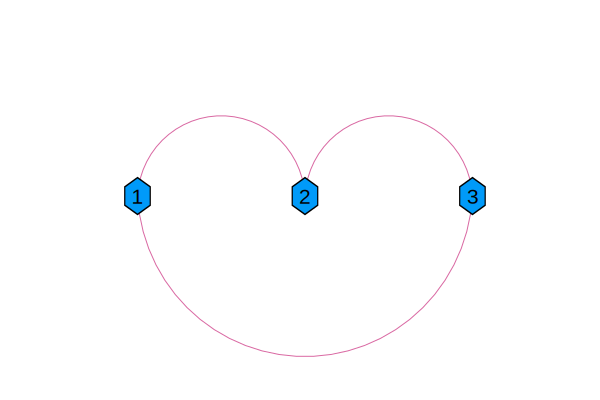

In [2]:
T1=PTree(3,[2,3,1]);

PlotTree(T1)

Not that this graph is closed and hence is not a tree.  **We should be able to check for loops.**
Thus tasks like getting the progeny or the corresponding beta matrix will not be possible


In [3]:
BetaMatrix(T1)


[3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2]

MethodError: MethodError: no method matching length(::Nothing)
Closest candidates are:
  length(!Matched::Core.SimpleVector) at essentials.jl:597
  length(!Matched::Base.MethodList) at reflection.jl:819
  length(!Matched::Core.MethodTable) at reflection.jl:893
  ...

The CheckParents performs such a check and modifies its input. In Julia functions that modify their arguments directly end in !; hence `CheckParents!`

In [4]:
CheckParents!(T1.Parents)

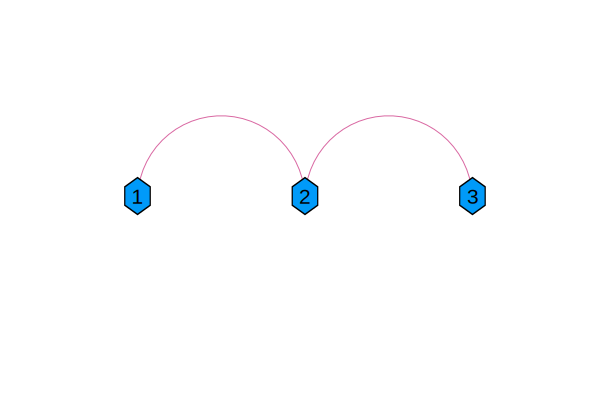

In [5]:
PlotTree(T1)

#### If the node has no parent, then a marker is stored instead of listing a parent 
e.g. $\mathcal T_2=[2 ,4, *,*]$. 

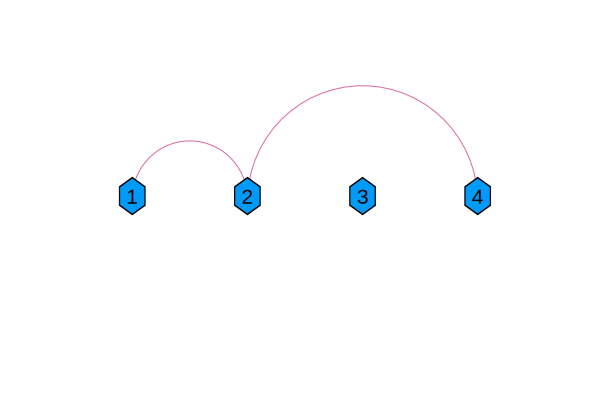

In [6]:
T2=PTree(4,[2,4,-1,-1]);
PlotTree(T2)

## Testing for loops

In [7]:
T=PTree(4,[3,2,1,-1])
print(T.Parents,"\n")
CheckParents!(T.Parents)
print(T.Parents)

[3, 2, 1, -1]
[3, -1, 4, -1]

## Testing interconversion with beta matrices

In [8]:
B=BetaMatrix(T)

4×4 Array{Int64,2}:
 1  1  0  1
 0  1  0  1
 0  0  1  0
 0  0  0  1

In [9]:
BetaToParents(B)

4-element Array{Int64,1}:
  3
 -1
  4
 -1

In [10]:
print(T2.Parents)
CheckParents!(T2.Parents)
print(T2.Parents)
BetaToParents(BetaMatrix(T2))

[2, 4, -1, -1][2, 4, -1, -1]

4-element Array{Int64,1}:
  2
  4
 -1
 -1

# Tree operations: Shift, Combine

We can shift the tree by shifting all indices by a constant amount. 

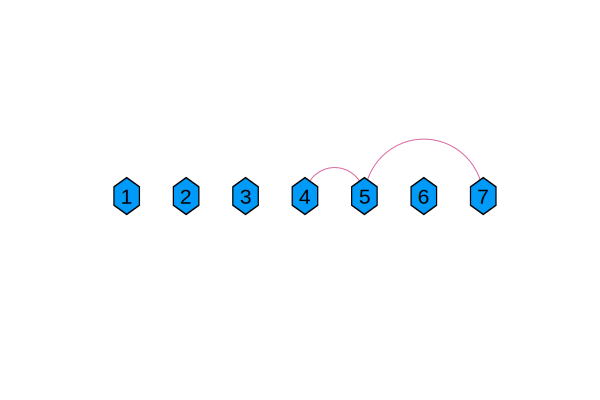

In [11]:
include("Trees.jl")
T3=ShiftTree(3,T2)
PlotTree(T3)

In [12]:
BetaMatrix(T3)

7×7 Array{Int64,2}:
 1  0  1  1  0  0  0
 0  1  0  0  0  0  0
 0  0  1  1  0  0  0
 0  0  0  1  0  0  0
 0  0  0  0  1  0  0
 0  0  0  0  0  1  0
 0  0  0  0  0  0  1

Here we can see the effect of chosing the alternative basis transform indexing.  The beta(1,1) matrix element corresponds to the presence of the occupancy of orbital M in value stored in node M.


The shift function allows two disjoint trees to be combined straightforwardly with one tree 
occupying the first $M_1$ nodes and the remaining $M_2=M-M_1$ 
nodes contain a shifted version of a tree on $M_2$ nodes 
e.g. $[\mathcal T_1,\mathcal T_2]=[2,3,1,5,7,-1,-1]$.

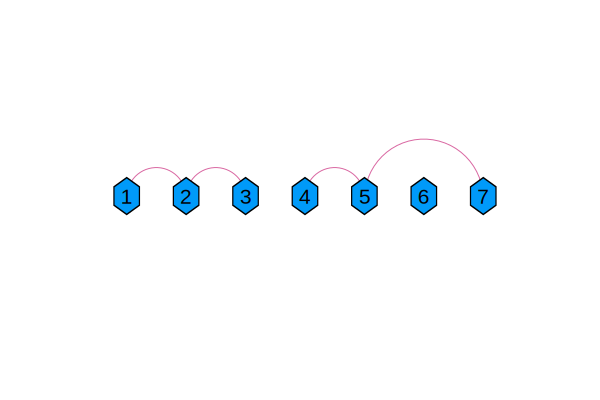

In [13]:
T4=CombineTrees(T1,T2)
PlotTree(T4)

Not that this operation is not symmetric.

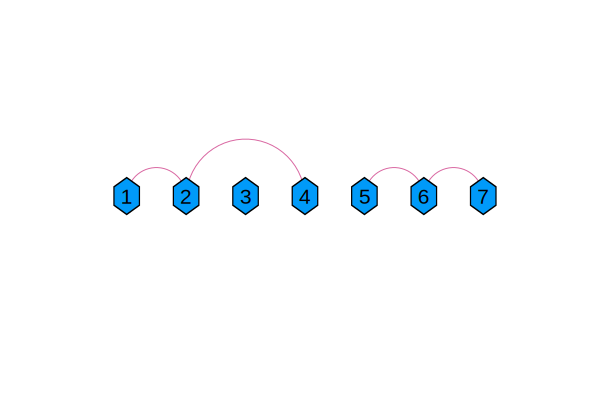

In [14]:
T5=CombineTrees(T2,T1)
PlotTree(T5)

## Example 2

In [15]:

M=10;
parentage=[ 2 , 3,  5,  5,  10,  7,  8,  10,  10,  -1];

#% PTree(num_of_sites,Parents)
t=PTree(M,parentage);

#for the Graph Recipes script we need a list of src to tgt
src=Int[]
tgt=Int[]

#loop through the parentage
for m=1:t.M
    if(t.Parents[m]>0)
      src=[src;m]
      tgt=[tgt;convert(Int,t.Parents[m])]
    else
      src=[src;m]
      tgt=[tgt;m]
    end
end
node_names=["one","two","three","four","five","six","seven","eight","nine","ten"]
graphplot(src,tgt, names=node_names, method=:tree,nodesize=min(3,t.M))
savefig("example.png") # Saves the CURRENT_PLOT as a .png
savefig("example.pdf") # Saves the plot from p as a .pdf vector graphic

We will need to define several family relations later for encoding and decoding 
information within the binary tree. The *ancestors* of a tree node are the 
collection of all parents of parents of the node. We use the term *children*
to refer to immediate children of the node. *Progeny* refers to all children of 
children i.e. the subtree rooted at that node. In our graph lexicon, the term
*cousins* takes a specific meaning whose use will be apparent later **ref**.  
Specifically, we consider cousins as the children of ancestors of a node.  Note 
that this not the progeny of the ancestry and hence differs from the familial 
definition of the term.  Also it should be noted that our definition of 
cousins also includes siblings.  We will only need the younger cousin set of 
a node which is the collection of cousins lower node index.

For the example depicted:

* Ancestors
  - The ancestors of node four are {5,10}
* Children
  - The children of node five is {3,4}
  - The children of node eight is {7}
* Younger cousins
  - The younger cousins of node nine are {5,8}
  - The younger cousins of node four is {3}
* Progeny
  - The progeny of node five are {1,2,3,4}

In [16]:
print("Ancestors(4,t)=",Ancestors(4,t),"\n")
print("Children(5,t)=",Children(5,t),"\n")
print("Children(8,t)=",Children(8,t),"\n")
print("YoungerCousins(9,t)=",YoungerCousins(9,t),"\n")
print("YoungerCousins(4,t)=",YoungerCousins(4,t),"\n")
print("Progeny(5,t)=",Progeny(5,t))


Ancestors(4,t)=[5, 10]
Children(5,t)=[3, 4]
Children(8,t)=[7]
YoungerCousins(9,t)=Any[5, 8]
YoungerCousins(4,t)=Any[3]
Progeny(5,t)=[3, 4, 2, 1]

## Example 2

In [17]:
#% PTree(num_of_sites,Parents)
M=10;
#Parents=[2,3,-1,5,6,-1,8,10,10,-1];
Parents=[-1,1,2,5,6,-1,8,10,10,-1];
t2=PTree(M,Parents);

#for the Graph Recipes script we need a list of src to tgt
src=Int[]
tgt=Int[]

#loop through the parentage
for m=1:t2.M
    if(t2.Parents[m]>0)
      src=[src;m]
      tgt=[tgt;convert(Int,t2.Parents[m])]
    else
      src=[src;m]
      tgt=[tgt;m]
    end
end
node_names=["one","two","three","four","five","six","seven","eight","nine","ten"]

graphplot(src,tgt, names=node_names, method=:tree, nodesize=min(3,t2.M))
#savefig("example2.png") # Saves the CURRENT_PLOT as a .png
savefig("example2.pdf") # Saves the plot from p as a .pdf vector graphic

![alt text](example2.pdf "Example 2 Tree")

Next we'll need to define the younger *disjoint roots* for a particular node. This is the set 
of nodes without a parent that have index less than the node under consideration. 
One could generate several graphic representations of the binary trees as illustrated 
in our work on the Hubbard model. 

* Younger disjoint roots
  - The younger disjoint roots of node nine are {6,1}
  - The younger disjoint roots of node seven are {6,1}
  - The younger disjoint roots of node six is {1}
* Beta matrix representation of tree

In [18]:
print("DisjointRoots(9,t2)=",DisjointRoots(9,t2),"\n")
print("DisjointRoots(7,t2)=",DisjointRoots(7,t2),"\n")
print("DisjointRoots(4,t2)=",DisjointRoots(4,t2),"\n")

DisjointRoots(9,t2)=Any[6, 1]
DisjointRoots(7,t2)=Any[6, 1]
DisjointRoots(4,t2)=Any[1]


In [19]:
BetaMatrix(t2)

10×10 Array{Int64,2}:
 1  1  1  1  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0
 0  0  1  1  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0
 0  0  0  0  1  1  1  0  0  0
 0  0  0  0  0  1  1  0  0  0
 0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  1  1  0
 0  0  0  0  0  0  0  1  1  1

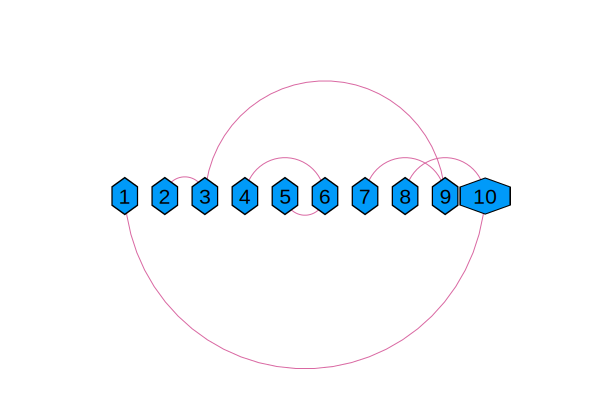

In [20]:
Parents=[-1,3,9,6,-1,5,9,10,-1,1];
t=PTree(10,Parents)
PlotTree(t)

In [21]:
t.Parents'

1×10 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 -1  3  9  6  -1  5  9  10  -1  1

[-1, 3, 9, 6, -1, 5, 9, 10, -1, 1]
[10, 3, 9, 6, 6, -1, 9, 10, -1, -1]


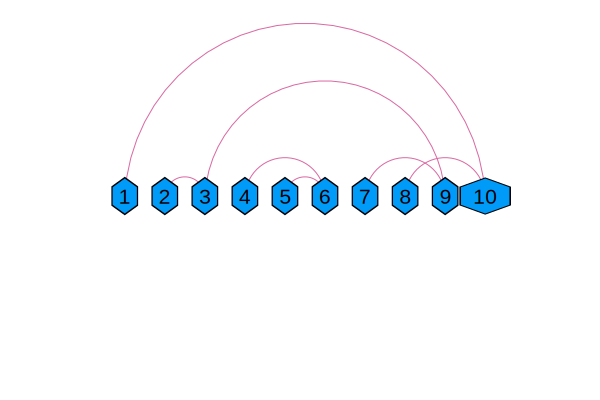

In [22]:
include("Trees.jl")
println([-1,3,9,6,-1,5,9,10,-1,1])
tt=PTree(10,[-1,3,9,6,-1,5,9,10,-1,1]);
CheckParents!(tt.Parents)
println(tt.Parents)
PlotTree(tt)

Note that the nodes are wired out of order, i.e. the parent-child relationships are not chronological. This manifests as lower triangular elements of the Beta matrix.

In [23]:
Progeny(1,t)

2-element Array{Int64,1}:
 10
  8

In [24]:
BetaMatrix(t)

10×10 Array{Int64,2}:
 1  0  1  0  0  0  0  0  0  0
 0  1  0  1  0  0  0  1  1  0
 0  0  1  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0
 0  0  0  0  1  0  1  0  0  0
 0  0  0  0  1  1  1  0  0  0
 0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  1  0
 0  0  0  0  0  0  0  0  1  0
 1  0  1  0  0  0  0  0  0  1

In [25]:
BetaMatrix(tt)

10×10 Array{Int64,2}:
 1  0  1  0  0  0  0  0  0  1
 0  1  0  1  0  0  0  1  1  0
 0  0  1  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0
 0  0  0  0  1  1  1  0  0  0
 0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  1  0
 0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  1

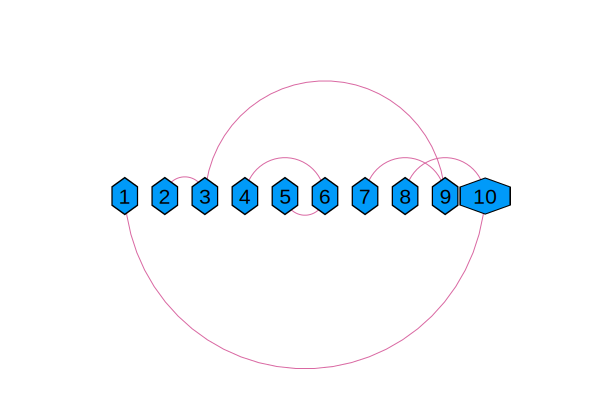

In [26]:
PlotTree(t)

## Tree constructors 

In the Julia library, a number of constructors exist to automate the construction of binary trees. 

In this section, the connection that the Fenwick tree offers between the 
Jordan-Wigner and the Bravyi-Kitaev encodings will be elucidated.  We will 
also cover the segmented Bravyi-Kitaev.  For now we will explain these concepts in terms of the tree terminology introduced earlier.

### Jordan-Wigner and the parity tree

The Jordan-Wigner tree is a binary tree with all orphans i.e. no parents.

In [27]:
jwt=JWTree(10)
jwt.Parents'

1×10 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 -1  -1  -1  -1  -1  -1  -1  -1  -1  -1

The parity tree is a binary tree with node $j$ child of node $j+1$. 

In [28]:
pt = ParityTree(M);
pt.Parents'

1×10 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 2  3  4  5  6  7  8  9  10  -1

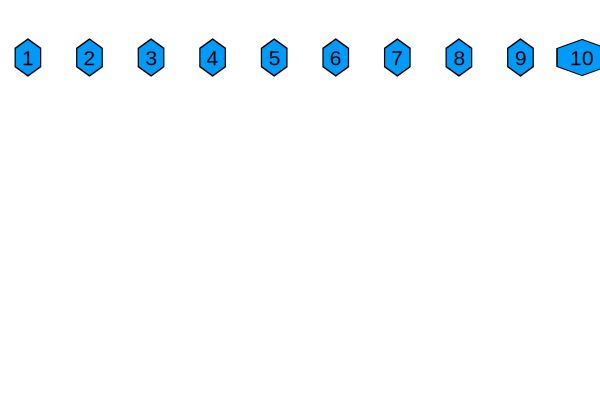

In [29]:
PlotTree(jwt)

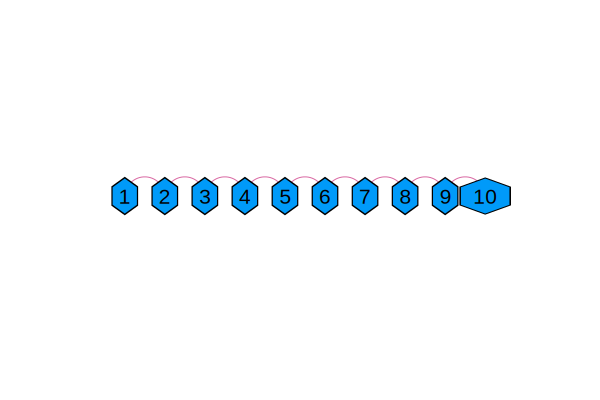

In [30]:
PlotTree(pt)

### Fenwick tree

Fenwick tree were introduced in 1991 for the purpose of algorithmic coding.  
Earlier applications to binomial heaps appeared in the 1970's.  They were 
rediscovered in 2000 by Bravyi and Kitaev in the context of quantum simulation.
Recent work has further analyzed and simplified the the Bravyi-Kitaev 
presentation including exploitation in an experimental implementation. 

Let us give a hereditary algorithm for generating the Fenwick tree by 
describing which bit strings are children of a given bit string.  Suppose we have a string with Hamming weight $h$. The immediate children of bit string $B$ in the tree are bit strings of Hamming weight $h-1$ where the flipping the first $0$ encountered beginning on the right returns $B$.  For example, $110101111$ has children $110101110$, $110101101$, $110101011$, and $110100111$. Alternate definitions can easily be found but worked examples are the fastest way to familiarize oneself with the application of this definition.

The recursive function FENWICK that Vojta suggested in our previous paper is
below and is the basis for the Julia implementation. To actually construct a 
tree over $M$ nodes, one must run FENWICK(0,M-1).  Note that the Fenwick tree 
is the binary tree of the Bravyi-Kitaev transform.

The key idea for construction is to connect the node from middle between L and R to the righthand node then recuse on each half.

[2, 3, 5, 5, 10, 7, 8, 10, 10, -1]

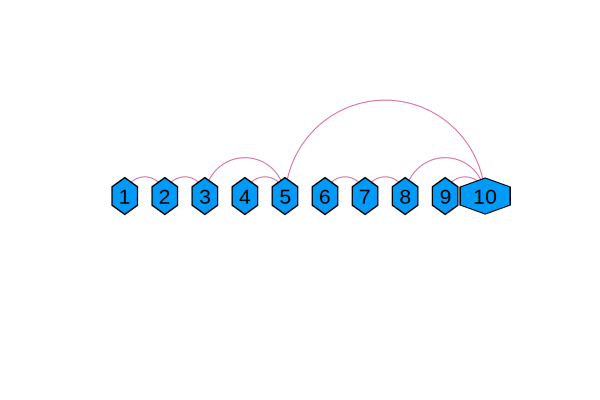

In [31]:
M=10
ft_array = MakeFenwickTree(M)
print(ft_array)

PlotTree(PTree(M,ft_array))

[2, 3, 5, 5, 9, 7, 9, 9, -1]

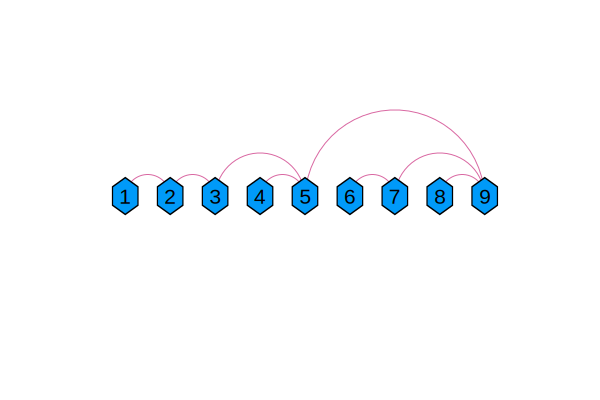

In [32]:
M=9
ft_array = MakeFenwickTree(M)
print(ft_array)

PlotTree(PTree(M,ft_array))


[2, 3, 5, 5, 10, 7, 8, 10, 10, -1]

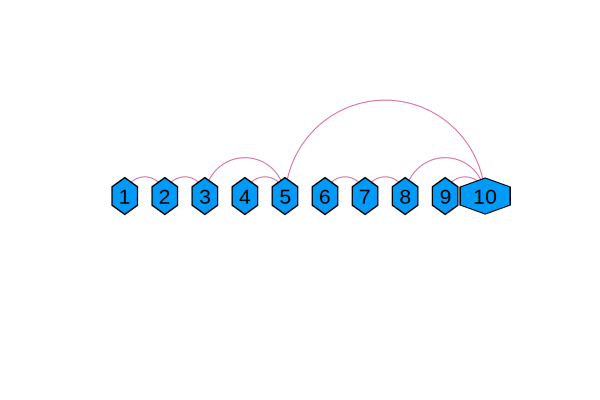

In [33]:
M=10
ft_array = MakeFenwickTree(M)
print(ft_array)

PlotTree(PTree(M,ft_array))

### Segmented Bravyi-Kitaev tree

Multiple Fenwick trees can be used to construct the
full binary tree of the system.  This is what we called the segmented Bravyi-
Kitaev technique.  The Jordan-Wigner tree is the completely segmented Bravyi-
Kitaev scheme whereby each node has Fenwick trees of depth 0.  In our previous
work, we also considered segmented Bravyi-Kitaev with constant stride length
$l$.  Thus, we focus on this case here.  Here, $M/l$ Fenwick trees of size $l$
are used to construct the binary tree.  This particularly useful when a row
structure is present in the interactions.

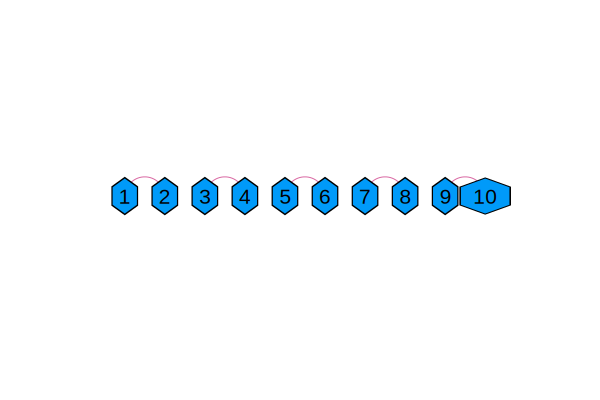

In [34]:
M=10; L=2;
sbkt=SBKTree(M,L)
PlotTree(sbkt)

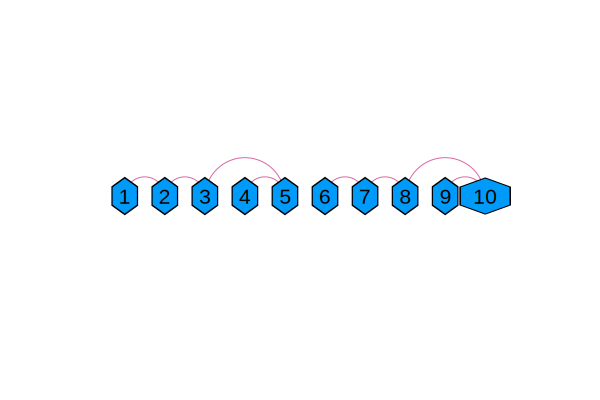

In [35]:
M=10; L=5;
sbkt=SBKTree(M,L)
PlotTree(sbkt)

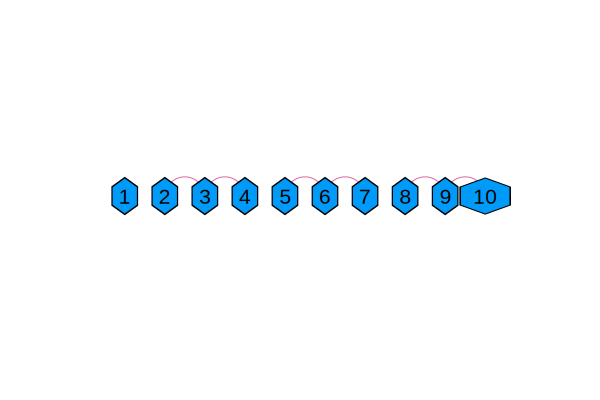

In [36]:
M=10; L=3;
sbkt=SBKTree(M,L)
PlotTree(sbkt)

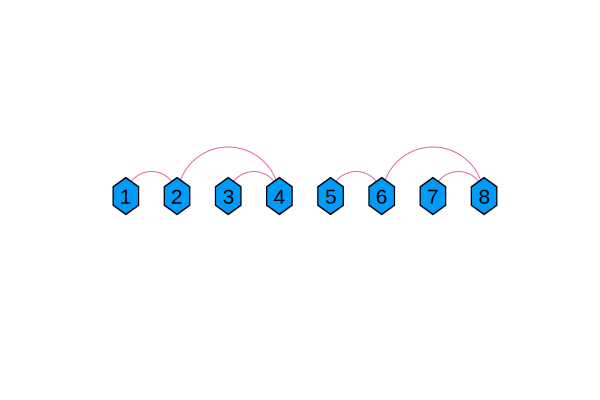

In [37]:
M=8; L=4;
sbkt=SBKTree(M,L)
PlotTree(sbkt)

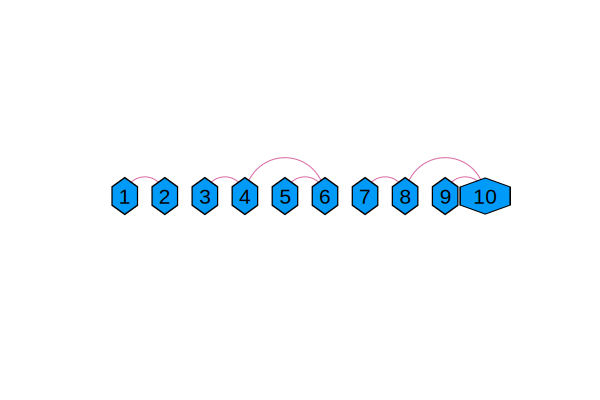

In [38]:
M=10; L=4;
sbkt=SBKTree(M,L)
PlotTree(sbkt)

# Random trees

  0.052674 seconds (10.66 k allocations: 710.184 KiB)


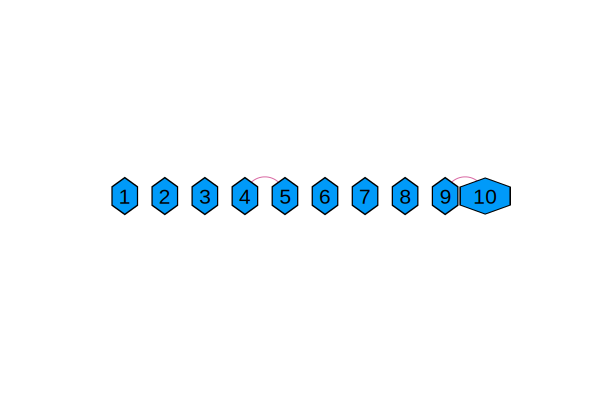

In [39]:
@time include("Trees.jl")
PlotTree(RandomTree(10))

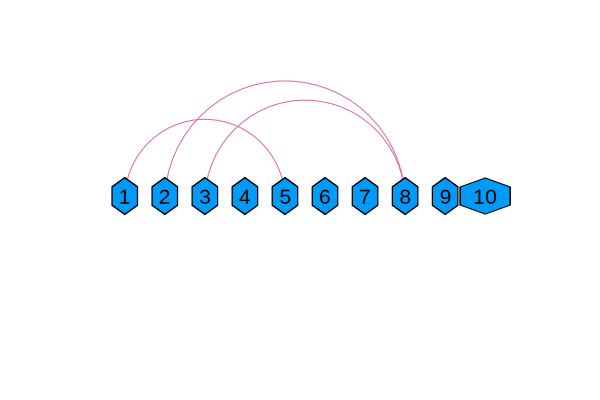

In [40]:
PlotTree(RandomTree(10))

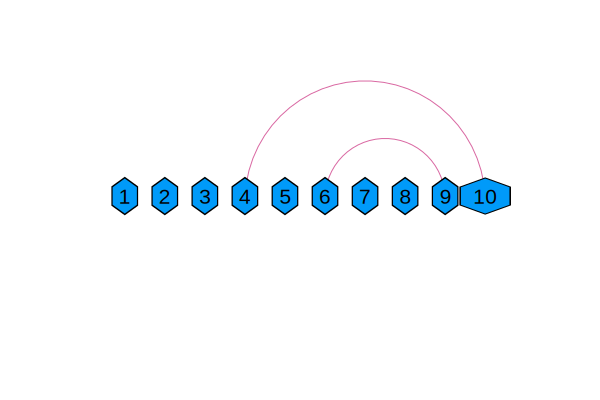

In [41]:
PlotTree(RandomTree(10))